Top 5 performing stocks: ['NVDA']
Epoch 1/30
18/18 [==============================] - 3s 5ms/step - loss: 0.0276
Epoch 2/30
18/18 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 3/30
18/18 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 4/30
18/18 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 5/30
18/18 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 6/30
18/18 [==============================] - 0s 5ms/step - loss: 9.3671e-04
Epoch 7/30
18/18 [==============================] - 0s 5ms/step - loss: 9.1477e-04
Epoch 8/30
18/18 [==============================] - 0s 5ms/step - loss: 9.0735e-04
Epoch 9/30
18/18 [==============================] - 0s 5ms/step - loss: 9.0874e-04
Epoch 10/30
18/18 [==============================] - 0s 5ms/step - loss: 9.3395e-04
Epoch 11/30
18/18 [==============================] - 0s 5ms/step - loss: 9.3522e-04
Epoch 12/30
18/18 [==============================] - 0s 5ms/step - loss

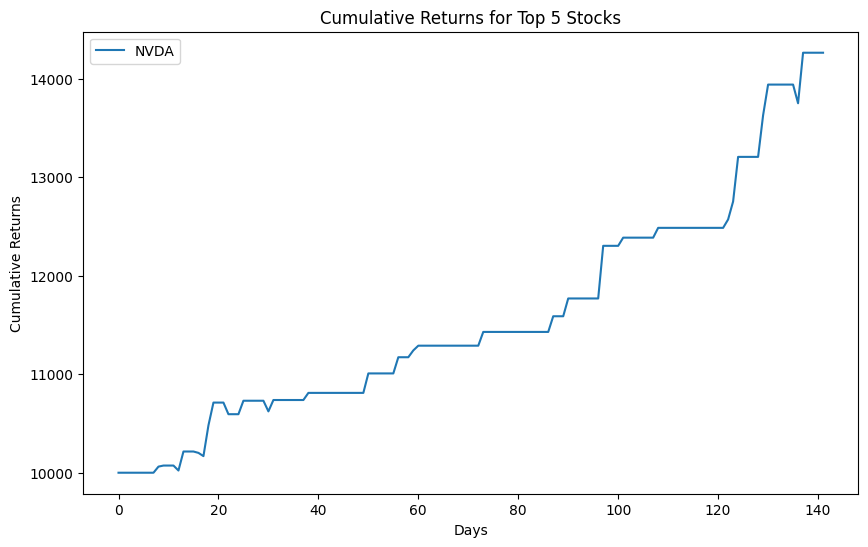

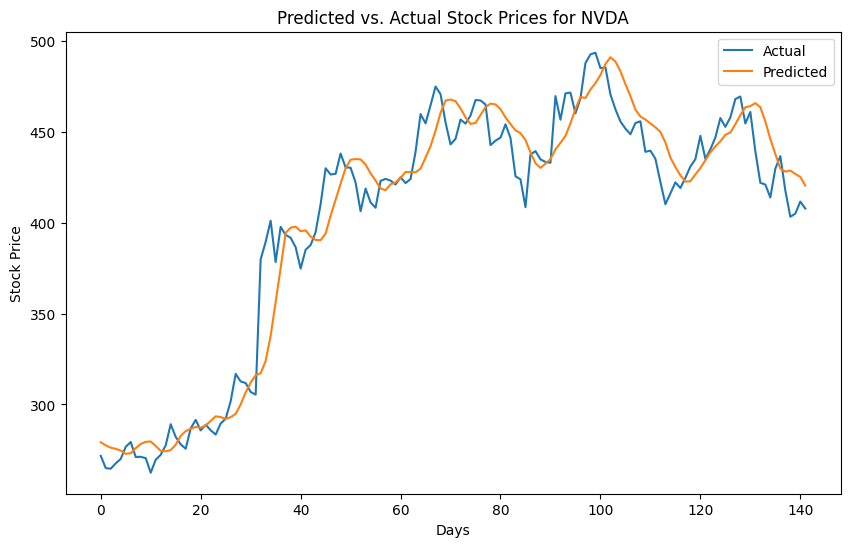

In [3]:

import numpy as np
import pandas as pd
from collections import deque
import random
import yfinance as yf
import matplotlib.pyplot as plt

# Import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Import Sequential and LSTM from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout  # Add LSTM here


# Fetch Dow Jones 30 stocks and preprocess data

def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-11-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()
        data[ticker] = stock_data.dropna()
    return data

tickers = ['NVDA']

data = fetch_data(tickers)

# Sort by performance and pick the top 5
sorted_tickers = sorted(tickers, key=lambda x: data[x]['Return'].sum(), reverse=True)[:5]
print("Top 5 performing stocks:", sorted_tickers)

# Initialize a dictionary to store cumulative returns and predicted versus actual results
cumulative_returns_dict = {}
predicted_vs_actual_dict = {}

# Iterate over the top 5 performing stocks
for ticker in sorted_tickers:
    # LSTM Model for the stock
    df = data[ticker].copy()
    df.dropna(inplace=True)

    # Scaling and reshaping for LSTM
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Close']].values)

    X, y = [], []
    for i in range(5, len(scaled_data)):
        X.append(scaled_data[i-5:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data
    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=30, batch_size=32)

    # Predictions
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    df['Predicted'] = np.nan
    df.iloc[-len(predicted):, df.columns.get_loc('Predicted')] = predicted

    # Trading Strategy
    test = df[-len(predicted):].copy()
    test['Position'] = np.where(test['Predicted'] > test['Open'], 1, -1)

    # Calculate 5-day percentage change for test data
    test['5_Day_Pct_Change'] = test['Close'].pct_change(periods=5)

    # Portfolio variables
    initial_balance = 10000.00
    balance = initial_balance

    # Track cumulative returns
    cumulative_returns = []

    # Trading logic for each test day
    for idx, row in test.iterrows():
        predicted_close = row['Predicted']
        actual_close = row['Close']
        open_price = row['Open']
        five_day_pct_change = row['5_Day_Pct_Change']

        if predicted_close > open_price and five_day_pct_change > 0:
            if actual_close > open_price:
                balance += (actual_close - open_price) * (balance / open_price)
            else:
                balance -= (open_price - actual_close) * (balance / open_price)
        elif predicted_close < open_price and five_day_pct_change < 0:
            if actual_close < open_price:
                balance += (open_price - actual_close) * (balance / open_price)
            else:
                balance -= (actual_close - open_price) * (balance / open_price)

        cumulative_returns.append(balance)

    # Store cumulative returns and predicted versus actual results
    cumulative_returns_dict[ticker] = cumulative_returns
    predicted_vs_actual_dict[ticker] = (predicted, actual)

# Plot cumulative returns for each stock
plt.figure(figsize=(10, 6))
for ticker, returns in cumulative_returns_dict.items():
    plt.plot(returns, label=ticker)

plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns for Top 5 Stocks")
plt.legend()
plt.show()

# Plot predicted versus actual results for each stock
for ticker, (predicted, actual) in predicted_vs_actual_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual")
    plt.plot(predicted, label="Predicted")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.title(f"Predicted vs. Actual Stock Prices for {ticker}")
    plt.legend()
    plt.show()


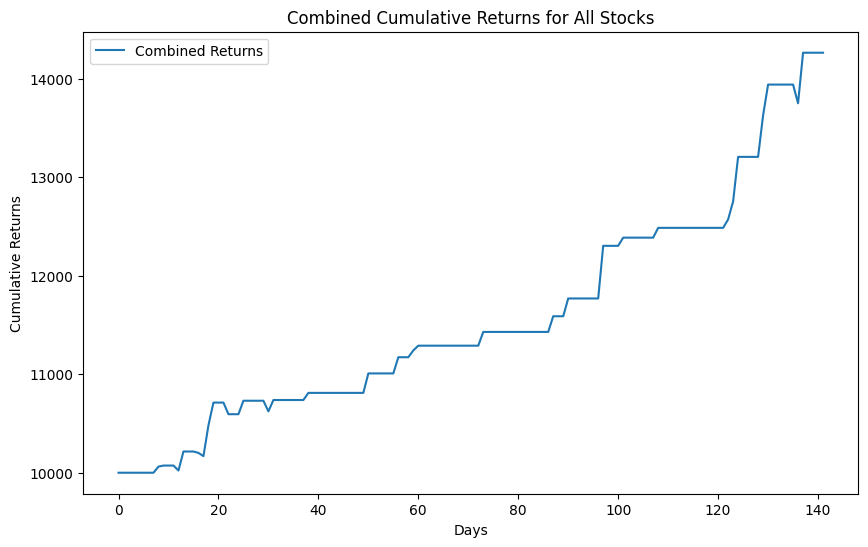

In [4]:
# Assuming 'cumulative_returns_dict' contains the cumulative returns for each stock

# Initialize a list to hold the combined cumulative returns
combined_cumulative_returns = []

# Get the number of days (or data points) for the cumulative returns
num_days = min(len(returns) for returns in cumulative_returns_dict.values())

# Calculate combined returns at each time point
for i in range(num_days):
    combined_return_at_i = sum(returns[i] for returns in cumulative_returns_dict.values())
    combined_cumulative_returns.append(combined_return_at_i)

# Plot combined cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(combined_cumulative_returns, label="Combined Returns")

plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("Combined Cumulative Returns for All Stocks")
plt.legend()
plt.show()
